In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
df = pd.read_csv('player_features.csv')
print(df.shape)
df.head()

# Numeric overview
display(df.describe().T.assign(missing=lambda d: df.isna().sum()))

# Count of seasons & colleges
print("Seasons:", df['season'].nunique())
print("Colleges:", df['college'].nunique())

(2065, 56)


,count,mean,std,min,25%,50%,75%,max,missing
player_number_ind,2065.0,17.040678,12.395348,0.000000,5.000000,15.000000,24.000000,55.000000,0
gp_ind,2065.0,20.311864,10.980011,1.000000,11.000000,25.000000,30.000000,36.000000,0
gs_ind,2065.0,10.182082,11.746382,0.000000,0.000000,3.000000,22.000000,35.000000,0
minutes_tot_ind,2065.0,410.265860,345.279436,0.000000,71.000000,344.000000,709.000000,1225.000000,0
scoring_pts_ind,2065.0,123.766102,131.299955,0.000000,14.000000,77.000000,202.000000,745.000000,0
rebounds_tot_ind,2065.0,64.047458,64.803076,0.000000,9.000000,48.000000,99.000000,419.000000,0
ast_ind,2065.0,26.008717,31.970567,0.000000,2.000000,15.000000,39.000000,232.000000,0
stl_ind,2065.0,16.014044,17.854258,0.000000,2.000000,11.000000,25.000000,135.000000,0
blk_ind,2065.0,6.104600,10.514603,0.000000,0.000000,2.000000,7.000000,121.000000,0
to_ind,2065.0,32.441162,30.135780,0.000000,6.000000,25.000000,52.000000,157.000000,0


Seasons: 21
Colleges: 13


In [5]:
# List columns with missing values
missing_columns = df.columns[df.isna().any()].tolist()
print("Columns with missing values:", missing_columns)


Columns with missing values: ['AST_per_TO', '2pt_pct', 'PPP', 'possessions', 'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100', 'blk_per100', 'to_per100']


In [6]:
# Load your dataset

for col in missing_columns:
    print(f"Column: {col}")
    missing = df[df[col].isna()]
    missing_players = missing[['player_ind', 'season']]
    print(missing_players)
    print("\n")
# # Find rows where AST_per_TO is missing (NaN)
# missing_ast_to = df[df['AST_per_TO'].isna()]

# # Return player names and season with missing AST/TO
# missing_players = missing_ast_to[['player_ind', 'season']]
# print(missing_players)


Column: AST_per_TO
                  player_ind   season
26              Emma Bedeker  2016-17
57               Jessica Lee  2021-22
70            Diamond Shavis  2018-19
82         Alexis Rosenfeld   2024-25
83       Caroline de Klauman  2024-25
...                      ...      ...
2004             Emily Brown  2012-13
2005       Bridget Whitfield  2012-13
2011          Sherika Salmon  2012-13
2033  Cristina Rojas Acevedo  2022-23
2064       Cinnamon Dockery   2020-21

[144 rows x 2 columns]


Column: 2pt_pct
                  player_ind   season
15              Emma Bedeker  2017-18
26              Emma Bedeker  2016-17
57               Jessica Lee  2021-22
83       Caroline de Klauman  2024-25
107             Becca Wilson  2023-24
...                      ...      ...
2017         Teresa Corchado  2012-13
2019          Lovisa Hagberg  2012-13
2020        Neechelle Ingram  2012-13
2034  Cristina Rojas Acevedo  2022-23
2064       Cinnamon Dockery   2020-21

[72 rows x 2 columns]


Co

In [7]:
for col in missing_columns:
    # Convert any infinities to NaN
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)

    # Fill NaNs with 0 and assign back
    df[col] = df[col].fillna(0)

    # Check for any remaining missing values
    missing_counts = df.isna().sum()
    print("Columns with missing values:\n", missing_counts[missing_counts > 0])

# Confirm no missing values remain
display(df.describe().T.assign(missing=lambda d: df.isna().sum()))

Columns with missing values:
 2pt_pct                72
PPP                    70
possessions            35
scoring_pts_per100     35
ast_per100             35
rebounds_tot_per100    35
stl_per100             35
blk_per100             35
to_per100              35
dtype: int64
Columns with missing values:
 PPP                    70
possessions            35
scoring_pts_per100     35
ast_per100             35
rebounds_tot_per100    35
stl_per100             35
blk_per100             35
to_per100              35
dtype: int64
Columns with missing values:
 possessions            35
scoring_pts_per100     35
ast_per100             35
rebounds_tot_per100    35
stl_per100             35
blk_per100             35
to_per100              35
dtype: int64
Columns with missing values:
 scoring_pts_per100     35
ast_per100             35
rebounds_tot_per100    35
stl_per100             35
blk_per100             35
to_per100              35
dtype: int64
Columns with missing values:
 ast_per100        

,count,mean,std,min,25%,50%,75%,max,missing
player_number_ind,2065.0,17.040678,12.395348,0.000000,5.000000,15.000000,24.000000,55.000000,0
gp_ind,2065.0,20.311864,10.980011,1.000000,11.000000,25.000000,30.000000,36.000000,0
gs_ind,2065.0,10.182082,11.746382,0.000000,0.000000,3.000000,22.000000,35.000000,0
minutes_tot_ind,2065.0,410.265860,345.279436,0.000000,71.000000,344.000000,709.000000,1225.000000,0
scoring_pts_ind,2065.0,123.766102,131.299955,0.000000,14.000000,77.000000,202.000000,745.000000,0
rebounds_tot_ind,2065.0,64.047458,64.803076,0.000000,9.000000,48.000000,99.000000,419.000000,0
ast_ind,2065.0,26.008717,31.970567,0.000000,2.000000,15.000000,39.000000,232.000000,0
stl_ind,2065.0,16.014044,17.854258,0.000000,2.000000,11.000000,25.000000,135.000000,0
blk_ind,2065.0,6.104600,10.514603,0.000000,0.000000,2.000000,7.000000,121.000000,0
to_ind,2065.0,32.441162,30.135780,0.000000,6.000000,25.000000,52.000000,157.000000,0


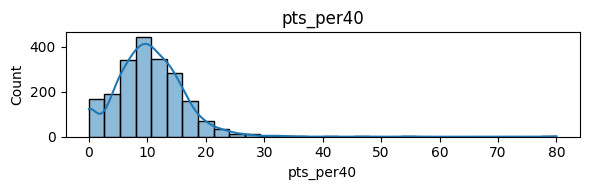

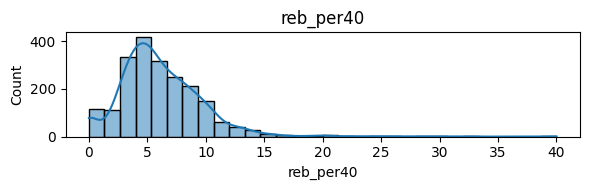

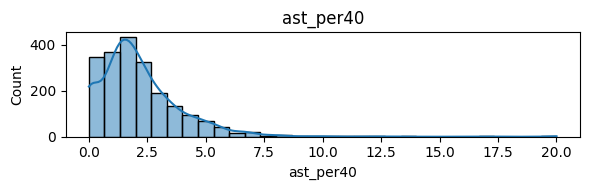

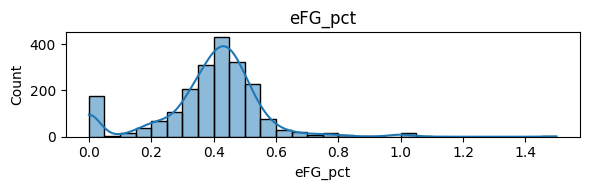

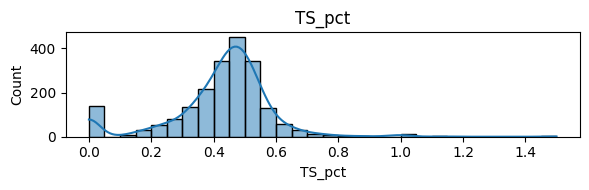

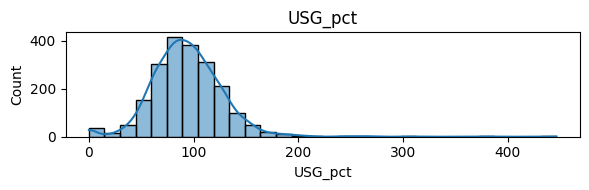

In [8]:
metrics = ['pts_per40','reb_per40','ast_per40','eFG_pct','TS_pct','USG_pct']

for m in metrics:
    plt.figure(figsize=(6,2))
    sns.histplot(df[m], kde=True, bins=30)
    plt.title(m)
    plt.tight_layout()
    plt.show()


In [9]:
# # correlation matrix of all numeric features
# corr = df.select_dtypes(float).corr()

# plt.figure(figsize=(10,8))
# sns.heatmap(corr, cmap='vlag', center=0, annot=False)
# plt.title("Feature Correlations")
# plt.show()


Feature pairs with |corr| > 0.9:
  gs_ind               <----> minutes_tot_ind      : 0.90
  minutes_tot_ind      <----> scoring_pts_ind      : 0.90
  eFG_pct              <----> TS_pct               : 0.93
  TS_pct               <----> PPP                  : 0.92
  minutes_tot_ind      <----> possessions          : 0.93
  scoring_pts_ind      <----> possessions          : 0.98
  to_ind               <----> possessions          : 0.91
  TS_pct               <----> scoring_pts_per100   : 0.94
  rebounds_tot_ind     <----> rebounds_tot_share   : 0.91
  DRB_pct              <----> rebounds_tot_share   : 0.94
  reb_per_game         <----> rebounds_tot_share   : 0.91
  eFG_pct              <----> TS_diff              : 0.91
  TS_pct               <----> TS_diff              : 0.97
  scoring_pts_per100   <----> TS_diff              : 0.91
  to_per100            <----> tov_rate             : 1.00
  scoring_pts_ind      <----> game_score           : 0.95
  possessions          <----> game_scor

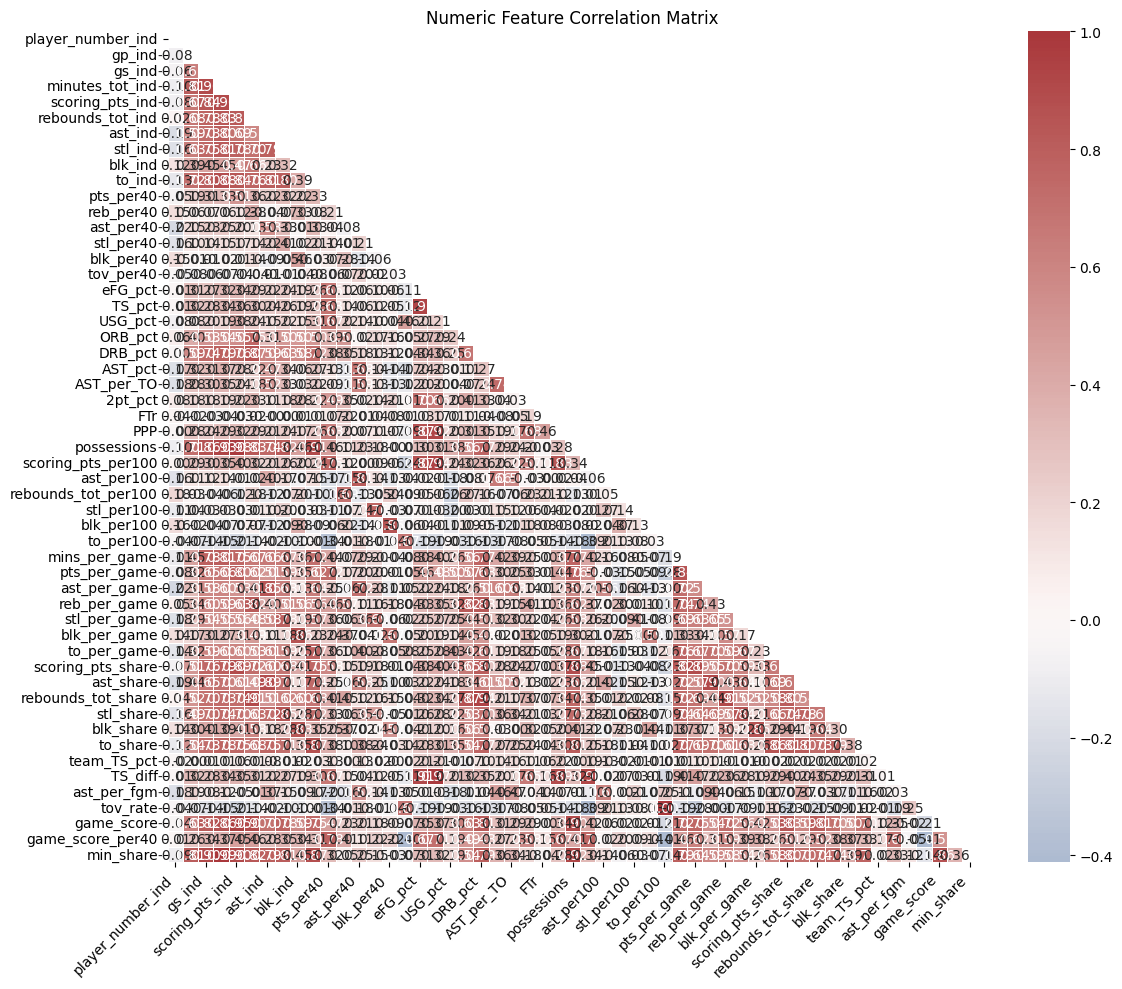

Number of columns df_reduced: 45
Number of columns df: 56


In [10]:
# assume df is already defined:
# df = pd.read_csv('player_features.csv')

# 1. Compute absolute correlation matrix of numeric columns
num_df       = df.select_dtypes(include=[np.number])
corr_matrix  = num_df.corr().abs()

# 2. Mask the lower triangle (so we don’t double‐count pairs or self‐correlations)
mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper      = corr_matrix.where(mask_upper)

# 3. Find all feature pairs with corr > threshold
threshold       = 0.9
high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if upper.loc[row, col] > threshold
]

# 4. Print them out
print(f"Feature pairs with |corr| > {threshold}:")
for col, row, corr_val in high_corr_pairs:
    print(f"  {row:20s} <----> {col:20s} : {corr_val:.2f}")

# 5. Optionally, pick one feature from each highly-correlated pair to drop:
to_drop = set(col for col, row, _ in high_corr_pairs)
print("\nFeatures to consider dropping:")
print(sorted(to_drop))

# 6. Drop them from your DataFrame
df_reduced = df.drop(columns=list(to_drop))


# ——————————————————————————————————————————————
# 7. Plot the full numeric-feature correlation heatmap
full_corr = num_df.corr()  # note: this is signed, not abs

# Generate mask for upper triangle
mask = np.triu(np.ones_like(full_corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    full_corr,
    mask=mask,
    cmap='vlag',
    center=0,
    annot=True,      # show correlation values
    fmt='.2f',       # 2 decimal places
    linewidths=0.5
)
plt.title("Numeric Feature Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Number of columns df_reduced:", df_reduced.shape[1])
print("Number of columns df:", df.shape[1])




In [11]:
# # Copy the DataFrame
# df_reduced = df.copy()

# # List of columns to drop (from your high-corr output)
# cols_to_drop = ['TS_pct', 'minutes_tot_ind', 'scoring_pts_ind']

# # Drop them in-place on the copy
# df_reduced.drop(columns=cols_to_drop, inplace=True)

# # Quick check
# print("Remaining columns:", df_reduced.select_dtypes(include=[float, int]).columns.tolist())
# print(df_reduced.shape)

# print("Number of columns:", df_reduced.shape[1])


Numeric features: ['player_number_ind', 'gp_ind', 'gs_ind', 'rebounds_tot_ind', 'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40', 'ast_per40', 'stl_per40', 'blk_per40', 'tov_per40', 'eFG_pct', 'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO', '2pt_pct', 'FTr', 'ast_per100', 'rebounds_tot_per100', 'stl_per100', 'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game', 'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game', 'to_per_game', 'scoring_pts_share', 'ast_share', 'stl_share', 'blk_share', 'to_share', 'team_TS_pct', 'ast_per_fgm', 'game_score_per40']

Top skewed features:
 tov_per40     11.329819
blk_per40      6.368556
stl_per100     6.172980
blk_per100     5.257139
ast_per100     4.860424
dtype: float64
Log-transforming: ['tov_per40', 'blk_per40', 'stl_per100', 'blk_per100', 'ast_per100', 'ast_per_fgm', 'FTr', 'blk_ind', 'blk_per_game', 'blk_share', 'stl_per40', 'ast_per40', 'to_per100', 'AST_per_TO', 'pts_per40', 'ast_ind', 'stl_ind', 'stl_

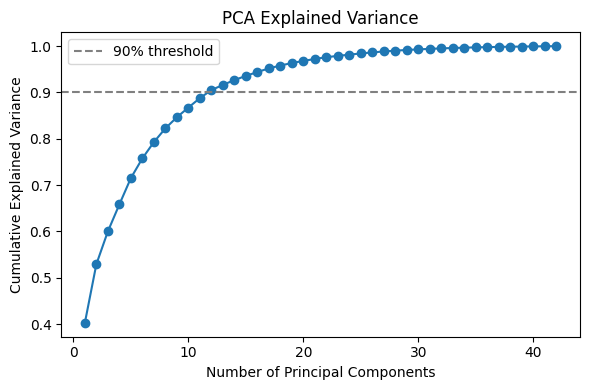

Retaining 12 components for ≥90% variance.


,college,season,player_ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,manhattan,2017-18,Kayla Grimme,6.088865,5.384980,-1.310726,0.169442,-1.615158,-1.230353,-0.325605,0.025729,-0.482202,-0.010598,0.684025,0.657004
1,manhattan,2017-18,Amani Tatum,7.238123,-3.662951,-1.819350,0.233243,0.590206,0.554248,-0.262469,-0.464406,0.265687,-0.369849,0.458924,0.194987
2,manhattan,2017-18,Gabby Cajou,5.039079,-3.412335,-0.124989,-0.476150,0.065661,1.037433,-1.169146,0.306354,0.057049,-0.347908,-0.383773,-0.743240
3,manhattan,2017-18,Mikki Guiton,-0.732683,1.510731,-0.593686,0.000362,1.044467,0.143046,1.486774,1.210851,0.058125,-0.363271,0.723615,0.114215
4,manhattan,2017-18,Taylor Williams,0.685365,-1.893788,-0.345722,-0.309766,-0.096560,0.627824,2.149221,0.272917,-0.399459,0.621137,0.342489,-0.052314


In [12]:
# Grab the numeric columns
numeric_cols = df_reduced.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric features:", numeric_cols)

# Quick check of skew to decide on log-transforming
skew_vals = df_reduced[numeric_cols].skew().abs().sort_values(ascending=False)
print("\nTop skewed features:\n", skew_vals.head(5))

# Identify features with |skew| > 1
skewed = skew_vals[skew_vals > 1].index.tolist()
print("Log-transforming:", skewed)

# Apply log1p in place
df_reduced[skewed] = np.log1p(df_reduced[skewed])

from sklearn.preprocessing import StandardScaler

# Scale to mean=0, SD=1 so PCA treats every feature equally
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_reduced[numeric_cols])

# Wrap back into a DataFrame for clarity
X_scaled = pd.DataFrame(X_scaled, columns=numeric_cols, index=df_reduced.index)


# Fit PCA without reducing dimensionality yet
pca_full = PCA()
pca_full.fit(X_scaled)

# Compute cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Plot the “elbow” in explained variance
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.90, color='gray', linestyle='--', label='90% threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

# Find the minimum k so that cum_var[k-1] ≥ 0.90
k_90 = np.argmax(cum_var >= 0.90) + 1
print(f"Retaining {k_90} components for ≥90% variance.")

# Re-fit PCA with that many components
pca = PCA(n_components=k_90)
X_pca = pca.fit_transform(X_scaled)

# Build a new DataFrame with your identifiers + PCs
id_cols = ['college', 'season', 'player_ind']  # adjust if your identifiers differ
pc_cols = [f'PC{i+1}' for i in range(k_90)]

df_pca = pd.concat([
    df_reduced[id_cols].reset_index(drop=True),
    pd.DataFrame(X_pca, columns=pc_cols)
], axis=1)

# Preview
df_pca.head()



In [14]:
# — Assumes you've already run PCA with n_components=k_90 and have:
#    pca (the fitted PCA object)
#    X_scaled (your standardized numeric feature DataFrame)
#    numeric_cols (list of your numeric feature names)

# 1) Build a loadings DataFrame: rows are original features, cols are PCs
loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_cols,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# 2) For the first 5 PCs, print the top 5 features by absolute loading
for pc in loadings.columns[::]:
    # sort by magnitude
    top_feats = loadings[pc].abs().sort_values(ascending=False).index[:5]
    print(f"\nTop features driving {pc}:")
    for feat in top_feats:
        val = loadings.loc[feat, pc]
        print(f"  {feat:20s} : {val:.3f}")



Top features driving PC1:
  ast_ind              : 0.217
  stl_ind              : 0.217
  rebounds_tot_ind     : 0.214
  mins_per_game        : 0.209
  pts_per_game         : 0.208

Top features driving PC2:
  blk_per40            : 0.319
  blk_per100           : 0.293
  blk_per_game         : 0.291
  blk_share            : 0.263
  ast_per40            : -0.252

Top features driving PC3:
  rebounds_tot_per100  : 0.330
  to_per100            : 0.330
  ast_per_fgm          : 0.276
  ast_per100           : 0.275
  scoring_pts_share    : -0.242

Top features driving PC4:
  tov_per40            : 0.423
  game_score_per40     : -0.377
  to_per100            : 0.368
  eFG_pct              : -0.322
  AST_pct              : -0.295

Top features driving PC5:
  pts_per40            : 0.312
  USG_pct              : 0.309
  blk_per100           : -0.272
  eFG_pct              : 0.264
  blk_per40            : -0.250

Top features driving PC6:
  stl_per40            : 0.535
  stl_per100           : 

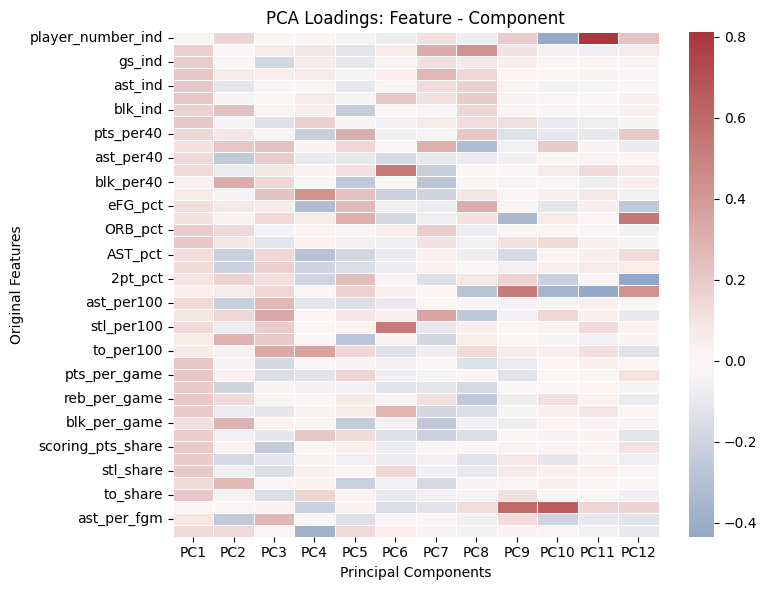

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    loadings,
    cmap='vlag',
    center=0,
    annot=False,      # set to True if you want the exact numbers
    linewidths=0.5
)
plt.title("PCA Loadings: Feature - Component")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.tight_layout()
plt.show()


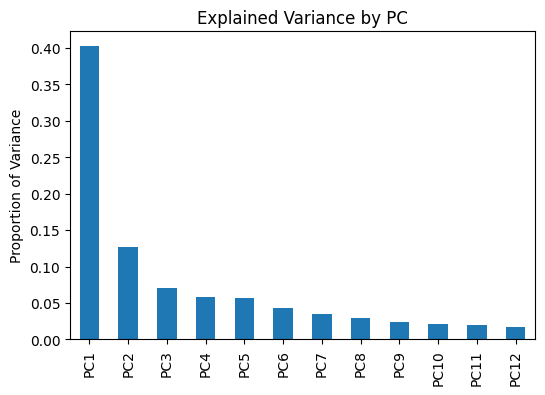

In [16]:
# Example: check explained variance per component
var_ratio = pca.explained_variance_ratio_
pd.Series(var_ratio, index=[f'PC{i+1}' for i in range(len(var_ratio))]).plot(
    kind='bar', figsize=(6,4), title='Explained Variance by PC'
)
plt.ylabel('Proportion of Variance')
plt.show()


In [17]:
# Assuming you've settled on n_final PCs (e.g. n_final = k_90 or a smaller number)

n_final = pca.n_components_  # or set manually, e.g. 8

# 1) Get the first n_final PC scores
pc_cols = [f'PC{i+1}' for i in range(n_final)]
X_pcs  = pd.DataFrame(pca.transform(X_scaled)[:, :n_final], columns=pc_cols)

# 2) Concatenate identifiers
id_cols = ['college', 'season', 'player_ind']  # adapt if needed
df_pca = pd.concat([df_reduced[id_cols].reset_index(drop=True), X_pcs], axis=1)

# 3) Preview
df_pca.head()


,college,season,player_ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,manhattan,2017-18,Kayla Grimme,6.088865,5.384980,-1.310726,0.169442,-1.615158,-1.230353,-0.325605,0.025729,-0.482202,-0.010598,0.684025,0.657004
1,manhattan,2017-18,Amani Tatum,7.238123,-3.662951,-1.819350,0.233243,0.590206,0.554248,-0.262469,-0.464406,0.265687,-0.369849,0.458924,0.194987
2,manhattan,2017-18,Gabby Cajou,5.039079,-3.412335,-0.124989,-0.476150,0.065661,1.037433,-1.169146,0.306354,0.057049,-0.347908,-0.383773,-0.743240
3,manhattan,2017-18,Mikki Guiton,-0.732683,1.510731,-0.593686,0.000362,1.044467,0.143046,1.486774,1.210851,0.058125,-0.363271,0.723615,0.114215
4,manhattan,2017-18,Taylor Williams,0.685365,-1.893788,-0.345722,-0.309766,-0.096560,0.627824,2.149221,0.272917,-0.399459,0.621137,0.342489,-0.052314


**Select the Most Appropriate PCs**

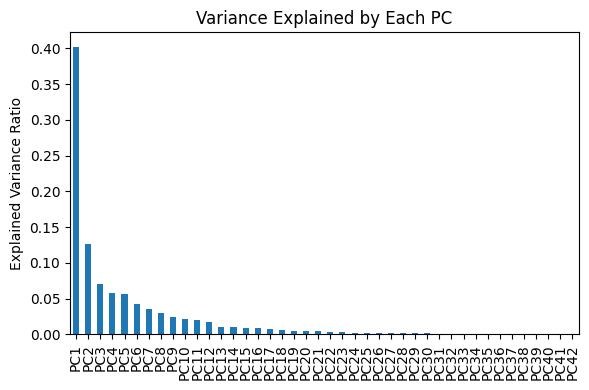

PCs 1–1: 40.24% cumulative variance
PCs 1–2: 52.91% cumulative variance
PCs 1–3: 59.99% cumulative variance
PCs 1–4: 65.81% cumulative variance
PCs 1–5: 71.51% cumulative variance
PCs 1–6: 75.77% cumulative variance
PCs 1–7: 79.28% cumulative variance
PCs 1–8: 82.25% cumulative variance
PCs 1–9: 84.65% cumulative variance
PCs 1–10: 86.74% cumulative variance
PCs 1–11: 88.78% cumulative variance
PCs 1–12: 90.53% cumulative variance
PCs 1–13: 91.63% cumulative variance
PCs 1–14: 92.69% cumulative variance
PCs 1–15: 93.58% cumulative variance
PCs 1–16: 94.43% cumulative variance
PCs 1–17: 95.20% cumulative variance
PCs 1–18: 95.82% cumulative variance
PCs 1–19: 96.36% cumulative variance
PCs 1–20: 96.82% cumulative variance
PCs 1–21: 97.24% cumulative variance
PCs 1–22: 97.62% cumulative variance
PCs 1–23: 97.90% cumulative variance
PCs 1–24: 98.17% cumulative variance
PCs 1–25: 98.43% cumulative variance
PCs 1–26: 98.65% cumulative variance
PCs 1–27: 98.86% cumulative variance
PCs 1–28: 

,college,season,player_ind,PC2,PC3,PC4,PC5,PC6,PC7
0,manhattan,2017-18,Kayla Grimme,5.384980,-1.310726,0.169442,-1.615158,-1.230353,-0.325605
1,manhattan,2017-18,Amani Tatum,-3.662951,-1.819350,0.233243,0.590206,0.554248,-0.262469
2,manhattan,2017-18,Gabby Cajou,-3.412335,-0.124989,-0.476150,0.065661,1.037433,-1.169146
3,manhattan,2017-18,Mikki Guiton,1.510731,-0.593686,0.000362,1.044467,0.143046,1.486774
4,manhattan,2017-18,Taylor Williams,-1.893788,-0.345722,-0.309766,-0.096560,0.627824,2.149221


In [18]:
# assume `pca_full` from your earlier PCA fit exists
var_ratio = pca_full.explained_variance_ratio_
pc_index = [f"PC{i+1}" for i in range(len(var_ratio))]

# Bar chart
plt.figure(figsize=(6,4))
pd.Series(var_ratio, index=pc_index).plot.bar()
plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Each PC")
plt.tight_layout()
plt.show()


cum_var = np.cumsum(var_ratio)
for i, cv in enumerate(cum_var, 1):
    print(f"PCs 1–{i}: {cv:.2%} cumulative variance")


# assume you have `loadings` from pca_full.components_.T
for pc in loadings.columns:
    # how much does the top feature load?
    max_loading = loadings[pc].abs().max()
    print(f"{pc}: top loading = {max_loading:.2f}")

high_var_pcs = [pc for pc, vr in zip(pc_index, var_ratio) if vr >= 0.03]
print("PCs ≥3% var:", high_var_pcs)

strong_loading_pcs = [pc for pc in loadings.columns
                     if loadings[pc].abs().max() >= 0.30]
print("PCs with at least one |loading| ≥0.30:", strong_loading_pcs)

final_pcs = [pc for pc in high_var_pcs if pc in strong_loading_pcs]
print("Final PCs to keep:", final_pcs)


df_final_pca = pd.concat([
    df_reduced[id_cols],
    pd.DataFrame(
        pca_full.transform(X_scaled)[:, [int(pc[2:]) - 1 for pc in final_pcs]],
        columns=final_pcs
    )
], axis=1)
df_final_pca.head()





**Clustering**

In [19]:
# Prepare PCA Input for Clustering
# Define which PCs to use from 'final_pcs' list

input_pcs = final_pcs  

# Build a NumPy array for clustering
X_cluster = df_final_pca[input_pcs].values

# Check shape: rows = players, cols = #PCs
print("Clustering on shape:", X_cluster.shape)


Clustering on shape: (2065, 6)


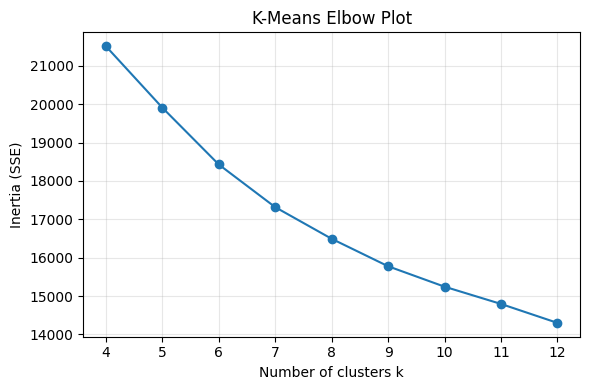

In [20]:
# K-Means Elbow Method
# Try k from 4 up to 12 (you want ~8, but check nearby)
Ks = range(4, 13)
inertias = []

for k in Ks:
    km = KMeans(
        n_clusters=k, 
        random_state=42, 
        n_init=10
    )
    km.fit(X_cluster)
    inertias.append(km.inertia_)

# 4.2.2.2 — Plot
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (SSE)')
plt.title('K-Means Elbow Plot')
plt.xticks(Ks)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


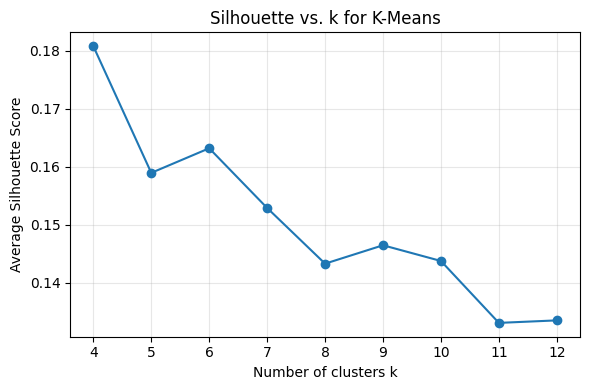

In [21]:
# K-Means Silhouette Method
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster)
    score  = silhouette_score(X_cluster, labels)
    sil_scores.append(score)

# Plot
plt.figure(figsize=(6,4))
plt.plot(Ks, sil_scores, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette vs. k for K-Means')
plt.xticks(Ks)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [33]:
# Final K-Means Clustering

# Fit K-Means with k=5
k_final = 6
km_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
labels_final = km_final.fit_predict(X_cluster)

# Add to PCA DataFrame
df_pca['km_cluster'] = labels_final
df_final_pca['km_cluster'] = labels_final
df_reduced['km_cluster'] = labels_final

# Compute overall silhouette
sil_final = silhouette_score(X_cluster, labels_final)
print(f"K-Means (k={k_final}) silhouette: {sil_final:.3f}")

# Check cluster sizes
cluster_sizes = pd.Series(labels_final).value_counts().sort_index()
print(f"Cluster sizes (k={k_final}):")
print(cluster_sizes)


K-Means (k=6) silhouette: 0.163
Cluster sizes (k=6):
0    347
1    398
2    602
3     57
4    140
5    521
Name: count, dtype: int64


**GMM + BIC**

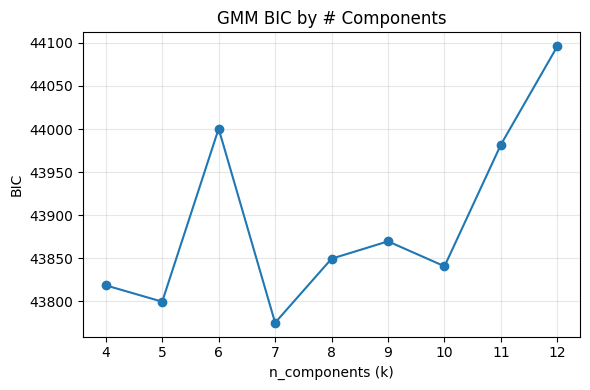

GMM selects k = 7


In [22]:
# Sweep k for BIC
bic_scores = []
for k in Ks:
    gm = GaussianMixture(n_components=k, random_state=42)
    gm.fit(X_cluster)
    bic_scores.append(gm.bic(X_cluster))

# Plot BIC
plt.figure(figsize=(6,4))
plt.plot(Ks, bic_scores, '-o')
plt.xlabel('n_components (k)')
plt.ylabel('BIC')
plt.title('GMM BIC by # Components')
plt.xticks(Ks)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Choose k with lowest BIC, e.g. k_gmm
k_gmm = Ks[np.argmin(bic_scores)]
print("GMM selects k =", k_gmm)

# Fit final GMM
gm_final = GaussianMixture(n_components=k_gmm, random_state=42)
df_final_pca['gmm_cluster'] = gm_final.fit_predict(X_cluster)


**Density-Based Clustering HDBSCAN**

In [23]:
# Narrow sweep for min_cluster_size to hit exactly desired number of clusters
results = []
for min_size in range(3, 13):
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=min_size,
        min_samples=max(1, int(min_size/2)),
        metric='euclidean'
    )
    labels = hdb.fit_predict(X_cluster)
    
    # count clusters (exclude -1)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    noise_pct  = (labels == -1).mean() * 100
    
    results.append({
        'min_size':    min_size,
        'n_clusters':  n_clusters,
        'noise_%':     f"{noise_pct:.1f}%",
    })

tune_df = pd.DataFrame(results)
print(tune_df.to_string(index=False))


/Users/savvasneofytou/Desktop/data-driven-framework-for-athlete-profiling-1/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/savvasneofytou/Desktop/data-driven-framework-for-athlete-profiling-1/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/savvasneofytou/Desktop/data-driven-framework-for-athlete-profiling-1/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/savvasneofytou/Desktop/data-driven-framework-for-athlete-profiling-1/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_

 min_size  n_clusters noise_%
        3         228   50.2%
        4           7    4.6%
        5           6    4.8%
        6           5   15.4%
        7           4   15.6%
        8           4   15.7%
        9           4   15.7%
       10           2    9.1%
       11           2    9.1%
       12           2    9.4%


In [ ]:
# Fit HDBSCAN with min_cluster_size (lowest noise % )
best_min = 4
hdb = hdbscan.HDBSCAN(
    min_cluster_size=best_min,
    min_samples=int(best_min/2),
    metric='euclidean'
)
labels = hdb.fit_predict(X_cluster)
df_final_pca['hdb_cluster'] = labels

# Check final cluster counts and noise
counts = df_final_pca['hdb_cluster'].value_counts().sort_index()
noise_pct = (labels == -1).mean() * 100
print("Final HDBSCAN cluster counts:")
print(counts)
print(f"\nNoise percentage: {noise_pct:.1f}%")

# Compute silhouette on non-noise points
mask = labels != -1
if mask.sum() > 1:
    hdb_sil = silhouette_score(X_cluster[mask], labels[mask])
else:
    hdb_sil = np.nan
print(f"\nHDBSCAN silhouette (non-noise): {hdb_sil:.3f}")


Final HDBSCAN cluster counts:
hdb_cluster
-1      96
 0       7
 1       4
 2    1913
 3       7
 4       9
 5       5
 6      24
Name: count, dtype: int64

Noise percentage: 4.6%

HDBSCAN silhouette (non-noise): 0.241


/Users/savvasneofytou/Desktop/data-driven-framework-for-athlete-profiling-1/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/savvasneofytou/Desktop/data-driven-framework-for-athlete-profiling-1/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
labels_hdb = df_final_pca['hdb_cluster']
mask       = labels_hdb != -1

if mask.sum() > 1:
    hdb_sil = silhouette_score(X_cluster[mask], labels_hdb[mask])
else:
    hdb_sil = np.nan

print("HDBSCAN silhouette (non-noise):", hdb_sil)

print("HDBSCAN label counts:")
print(df_final_pca['hdb_cluster'].value_counts())

HDBSCAN silhouette (non-noise): 0.24136716021861568
HDBSCAN label counts:
hdb_cluster
 2    1913
-1      96
 6      24
 4       9
 0       7
 3       7
 5       5
 1       4
Name: count, dtype: int64


**Review Clusters**

In [170]:
print("K-Means sizes:\n", df_final_pca['km_cluster'].value_counts())
print("\nGMM sizes:\n", df_final_pca['gmm_cluster'].value_counts())
print("\nHDBSCAN sizes (−1 = noise):\n", df_final_pca['hdb_cluster'].value_counts())


K-Means sizes:
 km_cluster
0    745
3    612
2    459
4    195
1     54
Name: count, dtype: int64

GMM sizes:
 gmm_cluster
4    757
3    730
0    336
2    190
1     52
Name: count, dtype: int64

HDBSCAN sizes (−1 = noise):
 hdb_cluster
 3    1578
-1     421
 0      30
 4      14
 1      12
 2      10
Name: count, dtype: int64


**Spectral CLustering**

In [27]:
from sklearn.cluster import SpectralClustering

spec = SpectralClustering(
    n_clusters=6,
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42
)
labels_spec = spec.fit_predict(X_cluster)


**Agglomerative (Hierarchical) Clustering**

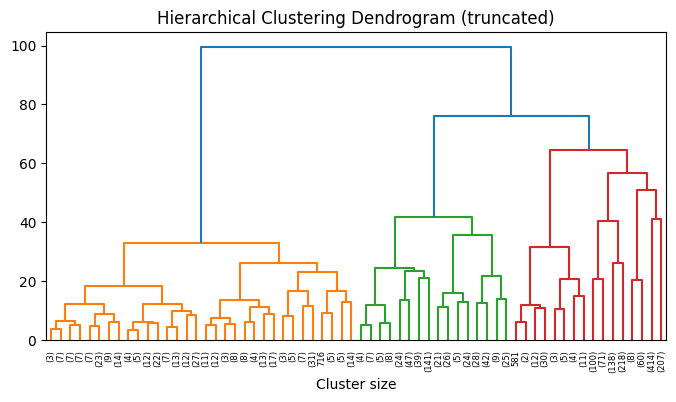

In [28]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 1) Plot dendrogram (using Ward linkage on your PCA space)
Z = linkage(X_cluster, method='ward')
plt.figure(figsize=(8, 4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster size")
plt.show()

# 2) Cut into, say, 6 clusters
agg6 = AgglomerativeClustering(n_clusters=6, linkage='ward')
labels_agg6 = agg6.fit_predict(X_cluster)


**Birch (Balanced Iterative Reducing and Clustering)**

In [ ]:
from sklearn.cluster import Birch

birch6 = Birch(n_clusters=6)
labels_birch6 = birch6.fit_predict(X_cluster)


**Affinity Propagation**

In [30]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(damping=0.9, preference=-50)
labels_ap = ap.fit_predict(X_cluster)


**Compare Custering Methods**

In [40]:
# ── Cell: Attach All Cluster Labels to df_final_pca ──

# 1) Spectral Clustering
from sklearn.cluster import SpectralClustering
spec = SpectralClustering(
    n_clusters=6,
    affinity='nearest_neighbors',
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=42
)
labels_spec = spec.fit_predict(X_cluster)
df_final_pca['spectral_cluster'] = labels_spec

# 2) Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
agg6 = AgglomerativeClustering(n_clusters=6, linkage='ward')
labels_agg6 = agg6.fit_predict(X_cluster)
df_final_pca['agg6_cluster'] = labels_agg6

# 3) Birch
from sklearn.cluster import Birch
birch6 = Birch(n_clusters=6)
labels_birch6 = birch6.fit_predict(X_cluster)
df_final_pca['birch_cluster'] = labels_birch6

# 4) Affinity Propagation
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation(damping=0.9, preference=-50, random_state=42)
labels_ap = ap.fit_predict(X_cluster)
df_final_pca['affinity_cluster'] = labels_ap

# 5) (Optionally) DBSCAN and OPTICS if you ran them earlier, e.g.:
from sklearn.cluster import DBSCAN, OPTICS
labels_db = DBSCAN(eps=0.5, min_samples=15).fit_predict(X_cluster)
df_final_pca['dbscan_cluster'] = labels_db
labels_opt = OPTICS(min_samples=15, xi=0.05, min_cluster_size=0.1).fit_predict(X_cluster)
df_final_pca['optics_cluster'] = labels_opt

# 6) Quick sanity check
print("df_final_pca shape:", df_final_pca.shape)
print("Cluster columns now present:")
print([c for c in df_final_pca.columns if c.endswith('_cluster')])

# 7) Show the first few rows
df_final_pca.head(5)


df_final_pca shape: (2065, 18)
Cluster columns now present:
['gmm_cluster', 'hdb_cluster', 'km_cluster', 'spectral_cluster', 'agg6_cluster', 'birch_cluster', 'affinity_cluster', 'dbscan_cluster', 'optics_cluster']


,college,season,player_ind,PC2,PC3,PC4,PC5,PC6,PC7,gmm_cluster,hdb_cluster,km_cluster,spectral_cluster,agg6_cluster,birch_cluster,affinity_cluster,dbscan_cluster,optics_cluster
0,manhattan,2017-18,Kayla Grimme,5.384980,-1.310726,0.169442,-1.615158,-1.230353,-0.325605,5,2,1,2,1,4,0,-1,0
1,manhattan,2017-18,Amani Tatum,-3.662951,-1.819350,0.233243,0.590206,0.554248,-0.262469,4,2,0,1,4,4,103,-1,0
2,manhattan,2017-18,Gabby Cajou,-3.412335,-0.124989,-0.476150,0.065661,1.037433,-1.169146,1,2,5,1,3,3,99,-1,0
3,manhattan,2017-18,Mikki Guiton,1.510731,-0.593686,0.000362,1.044467,0.143046,1.486774,5,2,2,0,1,3,72,-1,0
4,manhattan,2017-18,Taylor Williams,-1.893788,-0.345722,-0.309766,-0.096560,0.627824,2.149221,1,2,5,0,3,3,12,-1,0


In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score

# 1) Map each method to the column in df_reduced (or df_pca) that holds its labels
method_to_col = {
    'KMeans-6':        'km_cluster',
    'GMM':             'gmm_cluster',
    'HDBSCAN':         'hdb_cluster',        # or whatever you called it
    'Agglomerative-6': 'agg6_cluster',
    'DBSCAN':          'dbscan_cluster',
    'OPTICS':          'optics_cluster',
    'Spectral-6':      'spectral_cluster',
    'Birch-6':         'birch_cluster',
    'AffinityProp':    'affinity_cluster'
}

# 2) The PCA‐space array you clustered on
X_cluster = df_pca[[c for c in df_pca.columns if c.startswith('PC')]].values

# 3) Loop and evaluate
records = []
for method, col in method_to_col.items():
    labels = df_final_pca[col].values
    unique_labels = np.unique(labels)
    # count real clusters (exclude noise = -1 if present)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    # cluster sizes
    sizes = pd.Series(labels).value_counts().sort_index().to_dict()
    # silhouette on non-noise only
    if n_clusters > 1 and (-1 in labels):
        mask = labels != -1
        sil = silhouette_score(X_cluster[mask], labels[mask])
    elif n_clusters > 1:
        sil = silhouette_score(X_cluster, labels)
    else:
        sil = np.nan
    records.append({
        'Method':     method,
        'Clusters':   n_clusters,
        'Silhouette': sil,
        'Sizes':      sizes
    })

# 4) Build & show summary table (without .style)
summary = pd.DataFrame(records).set_index('Method')

# Round the silhouette scores to 3 decimal places
summary['Silhouette'] = summary['Silhouette'].round(3)

# Print the table
print(summary)




                 Clusters  Silhouette  \
Method                                  
KMeans-6                6       0.075   
GMM                     7       0.061   
HDBSCAN                 7       0.321   
Agglomerative-6         6       0.116   
DBSCAN                  0         NaN   
OPTICS                  1         NaN   
Spectral-6              6       0.146   
Birch-6                 6       0.131   
AffinityProp          123       0.098   

                                                             Sizes  
Method                                                              
KMeans-6           {0: 347, 1: 398, 2: 602, 3: 57, 4: 140, 5: 521}  
GMM              {0: 124, 1: 471, 2: 130, 3: 43, 4: 351, 5: 725...  
HDBSCAN          {-1: 96, 0: 7, 1: 4, 2: 1913, 3: 7, 4: 9, 5: 5...  
Agglomerative-6    {0: 705, 1: 408, 2: 205, 3: 475, 4: 237, 5: 35}  
DBSCAN                                                  {-1: 2065}  
OPTICS                                                   {0: 2065

In [51]:
# ── Attach cluster labels from df_final_pca into df ──

# 1) Make sure df and df_final_pca align
df = df.reset_index(drop=True)
df_final_pca = df_final_pca.reset_index(drop=True)

# 2) List of all the cluster columns you ran
cols = [
    'km_cluster',
    'gmm_cluster',
    'hdb_cluster',
    'agg6_cluster',
    'dbscan_cluster',     # if you ran it
    'optics_cluster',     # if you ran it
    'spectral_cluster',
    'birch_cluster',
    'affinity_cluster'
]

# 3) Copy them over (skip any that don’t exist)
for c in cols:
    if c in df_final_pca:
        df[c] = df_final_pca[c]

print("Now df.columns includes:", [c for c in cols if c in df])


Now df.columns includes: ['km_cluster', 'gmm_cluster', 'hdb_cluster', 'agg6_cluster', 'dbscan_cluster', 'optics_cluster', 'spectral_cluster', 'birch_cluster', 'affinity_cluster']


In [53]:
key_stats = [
    'pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40'
]
for method, col in {
    'KMeans-6':       'km_cluster',
    'Agglomerative-6':'agg6_cluster',
    'Birch-6':        'birch_cluster',
    'Spectral-6':     'spectral_cluster'
}.items():
    labels = df[col]
    print(f"\n=== {method} Centroids ===")
    cent = df.assign(cluster=labels).groupby('cluster')[key_stats].mean().round(2)
    cent.index = [f"Cluster {i}" for i in cent.index]
    display(cent)
    print(f"\n{method} Examples:")
    samples = (
        df.assign(cluster=labels)
               .groupby('cluster')['player_ind']
               .apply(lambda s: s.sample(3, random_state=42))
    )
    print(samples)



=== KMeans-6 Centroids ===


,pts_per40,eFG_pct,AST_per_TO,reb_per40,stl_per40,blk_per40
Cluster 0,11.01,0.36,0.73,4.12,1.67,0.17
Cluster 1,11.02,0.42,0.48,8.64,1.24,2.04
Cluster 2,11.70,0.40,0.48,7.17,1.31,0.36
Cluster 3,1.34,0.02,0.00,1.43,0.98,0.36
Cluster 4,17.19,0.60,1.00,4.85,1.21,0.14
Cluster 5,7.16,0.35,1.03,5.00,1.59,0.29



KMeans-6 Examples:
cluster      
0        1966           Reilly Sunday
         638             Ava Sollenne
         1978           Antonia Smith
1        1006         Valentina Pepic
         2056              Sky Castro
         134     Christina Katsamouri
2        381       Danielle Sanderlin
         1430           Sajada Bonner
         1938          Sajanna Bethea
3        26              Emma Bedeker
         111           Kristina Juric
         1385             Asia McCray
4        1605             Hannah Hand
         1128           Adila Gathers
         626           Brianna Rooney
5        1989         Teresa Corchado
         372          Tamara Miskovic
         19           Nyasha Irizarry
Name: player_ind, dtype: object

=== Agglomerative-6 Centroids ===


,pts_per40,eFG_pct,AST_per_TO,reb_per40,stl_per40,blk_per40
Cluster 0,8.50,0.36,0.64,5.67,1.17,0.60
Cluster 1,11.58,0.45,0.65,7.99,1.38,1.17
Cluster 2,7.64,0.26,0.01,5.84,0.88,0.67
Cluster 3,11.96,0.44,0.99,4.80,1.80,0.21
Cluster 4,14.79,0.45,0.91,7.34,2.00,0.51
Cluster 5,0.00,0.00,0.00,2.33,0.57,0.40



Agglomerative-6 Examples:
cluster      
0        1438    Afia Owusu-Mensah
         265             KC Carter
         257        Stacey Koutris
1        335         Tara Lonergan
         1018          Lore Porter
         1206        Emilee Tahata
2        151        Sheridan Heine
         108       Alyssa Costigan
         1128        Adila Gathers
3        1603           Allie Best
         1812        London Gamble
         34         Lizahya Morgan
4        986      Kaylee Stroemple
         124             Dee Davis
         1783       Teresa Seppala
5        1415        Montana Nicks
         788        Jazmine Carter
         1399         John Rigatti
Name: player_ind, dtype: object

=== Birch-6 Centroids ===


,pts_per40,eFG_pct,AST_per_TO,reb_per40,stl_per40,blk_per40
Cluster 0,11.46,0.45,0.49,8.80,1.24,1.61
Cluster 1,8.32,0.36,0.67,5.18,1.20,0.36
Cluster 2,6.88,0.24,0.01,5.76,0.90,0.67
Cluster 3,11.80,0.44,0.94,5.16,1.74,0.25
Cluster 4,15.03,0.45,0.93,7.59,1.95,0.81
Cluster 5,1.60,0.04,0.63,2.77,0.46,0.20



Birch-6 Examples:
cluster      
0        141          Crystal Ross
         1952     Neechelle Ingram
         421       Yasmine Djibril
1        1954      Teresa Corchado
         1009        Claire Wanzer
         281         Mariah Powell
2        1399         John Rigatti
         2005    Bridget Whitfield
         147      Courtney Hagaman
3        652          Rose Caverly
         824      Nicole Gallagher
         1560         Judith Gomez
4        457         Tiahana Mills
         1508           Tori Lesko
         596             Gal Raviv
5        1781       DeAnna Winston
         1164    Kristina Olikhver
         1285           Lauren Saa
Name: player_ind, dtype: object

=== Spectral-6 Centroids ===


,pts_per40,eFG_pct,AST_per_TO,reb_per40,stl_per40,blk_per40
Cluster 0,9.43,0.38,0.61,5.90,1.36,0.55
Cluster 1,12.40,0.44,1.04,5.04,1.84,0.25
Cluster 2,13.32,0.45,0.61,9.00,1.37,1.42
Cluster 3,0.00,0.00,0.00,2.33,0.57,0.40
Cluster 4,0.59,0.02,0.00,7.85,0.00,0.00
Cluster 5,3.61,0.11,0.01,3.70,0.00,0.64



Spectral-6 Examples:
cluster      
0        1352    Simon Mueller-landsv
         121          Nicole Anderson
         573             Sara Esidore
1        1156          Stella Johnson
         1966           Reilly Sunday
         1707        Julianna Bonilla
2        1318           Olivia Dabney
         640           Ella O'Donnell
         602            Caranda Perea
3        1415           Montana Nicks
         788           Jazmine Carter
         1399            John Rigatti
4        151           Sheridan Heine
         178           Stacey Koutris
         773           Jazmine Carter
5        761           Jazmine Carter
         14         Nyala Pendergrass
         1673           Nicole Decker
Name: player_ind, dtype: object


ValueError: Could not interpret value `PC1` for `x`. An entry with this name does not appear in `data`.

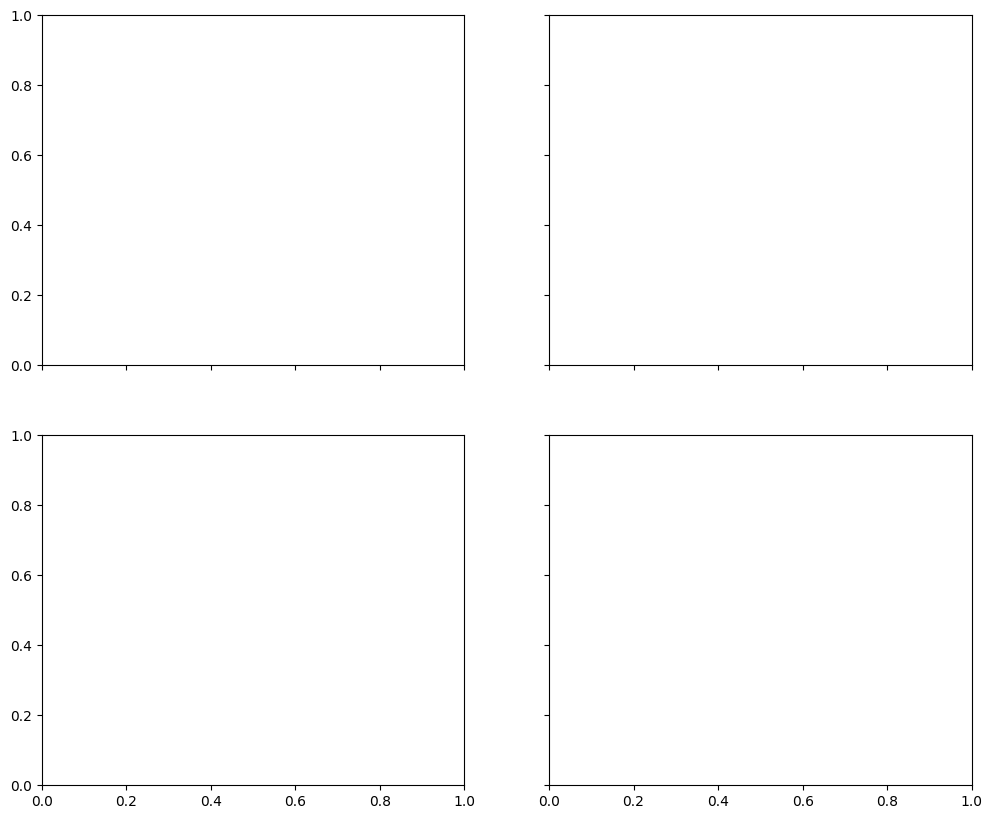

In [57]:
methods = ['km_cluster','agg6_cluster','birch_cluster','spectral_cluster']
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)

for ax, col in zip(axes.flatten(), methods):
    sns.scatterplot(
        x='PC1', y='PC2',
        hue=col,
        palette='tab10',
        data=df_final_pca,
        s=30,
        alpha=0.6,
        ax=ax
    )
    ax.set_title(col)
    ax.legend([],[], frameon=False)

plt.suptitle("Comparison of 6-Cluster Solutions in PC1–PC2 Space", y=1.02)
plt.tight_layout()
plt.show()


So HDBSCAN doesnt offer good results. one mega cluster and other small clusters even when use mis_size=4 (small noise) => only focus on fixed k methods(K_MEANS AND GMM)

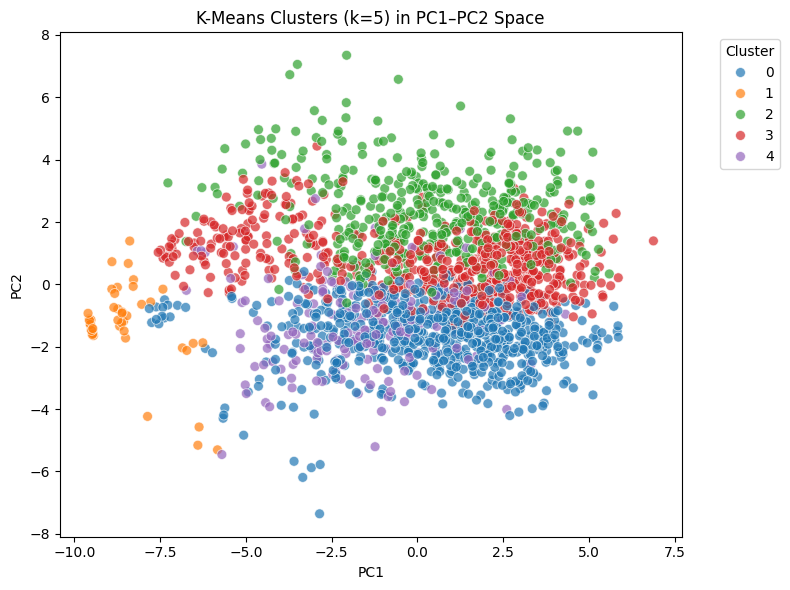

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure df_pca has 'PC1','PC2' and your final cluster column, e.g. 'km6_cluster' or 'km_cluster'
# Here, if you went with 6 clusters, use 'km6_cluster'; otherwise, use 'km_cluster' for 8.

cluster_col = 'km_cluster'   # or 'km_cluster' if you're plotting the 8-cluster solution
label_col   = 'archetype6_name'  # optional: human-readable labels

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue=cluster_col,
    palette='tab10',
    data=df_pca,
    s=50,
    alpha=0.7
)

# If you want to annotate with human-readable names instead of numeric hue:
# sns.scatterplot(x='PC1', y='PC2', hue=label_col, palette='tab10', data=df_pca, s=50, alpha=0.7)

plt.title(f"K-Means Clusters (k={df_pca[cluster_col].nunique()}) in PC1–PC2 Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


In [172]:
# Cluster sizes
print("K-Means cluster counts:")
print(df_final_pca['km_cluster'].value_counts().sort_index(), "\n")

print("GMM cluster counts:")
print(df_final_pca['gmm_cluster'].value_counts().sort_index(), "\n")

print("HDBSCAN cluster counts (-1 is noise):")
print(df_final_pca['hdb_cluster'].value_counts().sort_index(), "\n")

# Silhouette scores
km_sil = silhouette_score(X_cluster, df_final_pca['km_cluster'])
gmm_sil = silhouette_score(X_cluster, df_final_pca['gmm_cluster'])
# for HDBSCAN, drop noise:
mask = df_final_pca['hdb_cluster'] != -1
hdb_sil = silhouette_score(X_cluster[mask], df_final_pca.loc[mask, 'hdb_cluster'])
print(f"Silhouette — KMeans: {km_sil:.3f}, GMM: {gmm_sil:.3f}, HDBSCAN: {hdb_sil:.3f}\n")

# Cluster centroids in original feature space
# merge cluster labels back to your reduced original df
orig = df_reduced.reset_index(drop=True).copy()
orig['km_cluster']  = df_final_pca['km_cluster']
orig['gmm_cluster'] = df_final_pca['gmm_cluster']
orig['hdb_cluster'] = df_final_pca['hdb_cluster']

# pick key stats
keys = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']
print("K-Means centroids:")
print(orig.groupby('km_cluster')[keys].mean(), "\n")

print("GMM centroids:")
print(orig.groupby('gmm_cluster')[keys].mean(), "\n")

print("HDBSCAN centroids (-1 excluded):")
print(orig[orig['hdb_cluster']!=-1].groupby('hdb_cluster')[keys].mean(), "\n")

# Example players per cluster
print("K-Means examples:")
print(df_final_pca.groupby('km_cluster')['player_ind'].apply(lambda s: s.sample(3, random_state=42).tolist()), "\n")

print("GMM examples:")
print(df_final_pca.groupby('gmm_cluster')['player_ind'].apply(lambda s: s.sample(3, random_state=42).tolist()), "\n")

print("HDBSCAN examples (excluding noise):")
print(df_final_pca[df_final_pca['hdb_cluster']!=-1].groupby('hdb_cluster')['player_ind']
      .apply(lambda s: s.sample(3, random_state=42).tolist()))


K-Means cluster counts:
km_cluster
0    745
1     54
2    459
3    612
4    195
Name: count, dtype: int64 

GMM cluster counts:
gmm_cluster
0    336
1     52
2    190
3    730
4    757
Name: count, dtype: int64 

HDBSCAN cluster counts (-1 is noise):
hdb_cluster
-1     421
 0      30
 1      12
 2      10
 3    1578
 4      14
Name: count, dtype: int64 

Silhouette — KMeans: 0.138, GMM: 0.100, HDBSCAN: 0.230

K-Means centroids:
            pts_per40   eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
km_cluster                                                                  
0            2.128090  0.358132    0.617601   1.606438   0.914025   0.162973
1            0.188141  0.006173    0.000000   0.288736   0.255507   0.074210
2            2.310824  0.410401    0.357801   2.165992   0.727638   0.967118
3            2.407149  0.395808    0.349277   2.024641   0.756614   0.268330
4            2.536976  0.536958    0.676662   1.592369   0.632875   0.154790 

GMM centroids:
            

**Compare GMM to K-Means for k=8**

In [173]:
# K-Means with k=6
km8 = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_km8 = km8.fit_predict(X_cluster)
sil_km8    = silhouette_score(X_cluster, labels_km8)
sizes_km8  = pd.Series(labels_km8).value_counts().sort_index()

# GMM with n_components=7
gm8 = GaussianMixture(n_components=5, random_state=42)
labels_gm8 = gm8.fit_predict(X_cluster)
sil_gm8    = silhouette_score(X_cluster, labels_gm8)
sizes_gm8  = pd.Series(labels_gm8).value_counts().sort_index()

# Display comparison
print("Method    | Silhouette | Cluster sizes")
print("----------|------------|---------------")
print(f"K-Means   | {sil_km8:.3f}      | {sizes_km8.values}")
print(f"GMM       | {sil_gm8:.3f}      | {sizes_gm8.values}")

# Cluster centroids in original feature space (example for K-Means)
orig = df_reduced.reset_index(drop=True).copy()
orig['km8'] = labels_km8
keys = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']
print("\nK-Means (k=8) centroids:")
print(orig.groupby('km8')[keys].mean())


Method    | Silhouette | Cluster sizes
----------|------------|---------------
K-Means   | 0.138      | [745  54 459 612 195]
GMM       | 0.100      | [336  52 190 730 757]

K-Means (k=8) centroids:
     pts_per40   eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
km8                                                                  
0     2.128090  0.358132    0.617601   1.606438   0.914025   0.162973
1     0.188141  0.006173    0.000000   0.288736   0.255507   0.074210
2     2.310824  0.410401    0.357801   2.165992   0.727638   0.967118
3     2.407149  0.395808    0.349277   2.024641   0.756614   0.268330
4     2.536976  0.536958    0.676662   1.592369   0.632875   0.154790


**Verify CLusters and Archeotypes**

In [162]:
# # Pull the K-Means labels into df_reduced, then map to names

# # Make sure both frames are aligned row-wise
# df_reduced = df_reduced.reset_index(drop=True)
# df_final_pca = df_final_pca.reset_index(drop=True)

# # Copy the cluster assignments over
# df_reduced['km_cluster'] = df_final_pca['km_cluster']

# # Now define your archetype names
# archetype_map = {
#     0: "Defensive Big",
#     1: "Primary Scorer",
#     2: "Playmaker",
#     3: "Rebound Specialist",
#     4: "Secondary Scorer",
#     5: "Glue Role",
#     6: "3-and-D Wing",
#     7: "Slasher"
# }

# # Map the numeric cluster IDs to human-readable labels
# df_reduced['archetype_name'] = df_reduced['km_cluster'].map(archetype_map)

# # Quick sanity check
# print(df_reduced[['km_cluster','archetype_name','player_ind','college', 'season']])


In [163]:
# # 5.2 — Centroids of each archetype on key stats
# import matplotlib.pyplot as plt

# key_stats = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']

# # Group by archetype_name for readability
# centroids = df_reduced.groupby('archetype_name')[key_stats].mean().round(2)
# print("Archetype centroids (mean per-40 / ratios):")
# display(centroids)

# # Bar chart
# centroids.plot.bar(figsize=(12,6))
# plt.title("Archetype Profiles: Cluster Centroids")
# plt.ylabel("Mean per-40 / Ratio")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()


In [164]:
# # Recompute centroids, this time keeping the numeric cluster IDs as the index
# centroids_by_id = (
#     df_reduced
#     .groupby('km_cluster')[key_stats]
#     .mean()
#     .round(2)
# )

# print("Centroids by cluster ID:")
# display(centroids_by_id)


In [165]:
# Extended key stats
key_stats = [
    'pts_per40',   # scoring volume
    'eFG_pct',     # shooting efficiency
    'TS_pct',      # true shooting
    'USG_pct',     # usage
    'AST_per_TO',  # playmaking efficiency
    'AST_pct',     # assist rate
    'reb_per40',   # rebounding volume
    'ORB_pct',     # offensive rebound rate
    'DRB_pct',     # defensive rebound rate
    'stl_per40',   # perimeter defense
    'blk_per40',   # rim protection
    'FTr',         # free-throw rate (aggression)
    'PPP',         # points per attempt
    'pts_per100',  # pace-adjusted scoring
    'ast_per100',  # pace-adjusted passing
    'rebounds_tot_per100', # pace-adjusted rebounding
    'stl_per100',  # pace-adjusted steals
    'blk_per100',  # pace-adjusted blocks
    'to_per100'    # pace-adjusted turnovers
]

# 1.2 — Group by cluster ID and take means
cent6 = (
    df_reduced
    .groupby('km_cluster')[key_stats]
    .mean()
    .round(2)
)

# 1.3 — Display the centroid table
cent6.index = [f"Cluster {i}" for i in cent6.index]
print("Cluster centroids (k=6) on extended metrics:")
display(cent6)


KeyError: "Columns not found: 'pts_per100', 'PPP', 'TS_pct'"